<a href="https://colab.research.google.com/github/raphamatoss/DeepLearningWithPyTorch/blob/main/PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data: prepare and load
2. Build a model
3. Fit the model to the data(training)
4. Make predictions and evaluate a model
5. Save and load a model
6. Put it all together

In [1]:
import torch
from torch import nn # nn contains all of PyTorcg's building blocks for neural networks
import matplotlib.pyplot as plt

**1. DATA**

Data can be almost everything:
- DNA
- Imagens
- Music
- Text

We need to turn data into numbers and then build a model to learn patters in the numbers.
To showcase this, let´s create some known data using the linear regression formula. We'll make a straight line with know parameters.

In [12]:
# Create known parameters
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [17]:
len(X), len(y)

(50, 50)

**Splitting Data**

Training and testing sets are essencial in ML/DL, this division allow us to evaluate our model. There is also often a validation set, but it's not mandatory.

In [18]:
# Create a train/test split
train_split =  int(0.8 * len(X))
X_train, y_train =  X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [24]:
# Let's create a function to visualize our data!
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compare predictions
  """
  plt.figure(figsize=(10, 7))

  ### Plot training data in blue
  # matplotlib.pyplot.scatter takes (x=train_data, y=train_label) as the data position
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training set")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing set")

  if predictions is not None:
    # Plot the predictions in red(predictions made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


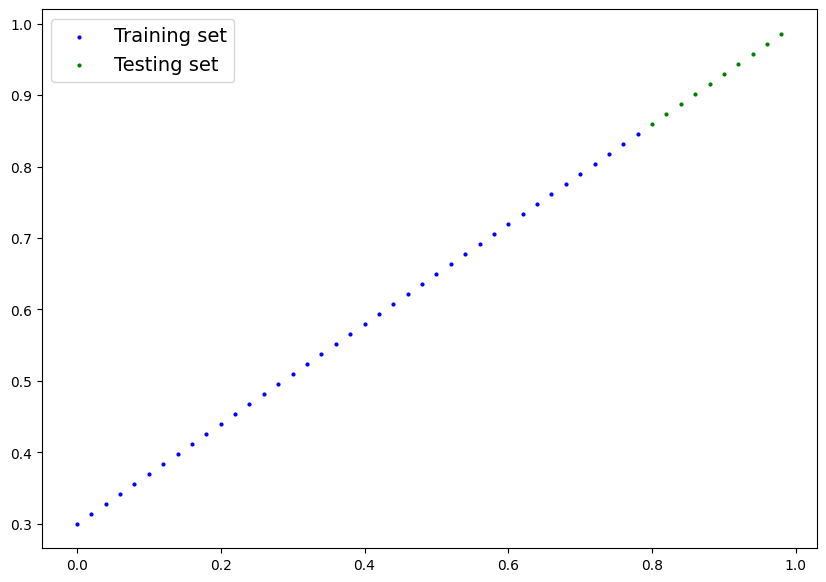

In [25]:
plot_predictions()